# Задание

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [1]:
# Импортируем библиотеки
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta

# Для визуализации графика в юпитерхабе
%matplotlib inline 

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv ')
order_items = pd.read_csv('olist_order_items_dataset.csv ')

## Предварительное исследование данных 

### Файл olist_customers_dataset

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.shape

(99441, 5)

In [5]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
#Количество уникальных пользователей
customers.customer_unique_id.nunique()

96096

In [8]:
#Посмотрим на полбзователей с >1 order_id
customers.groupby('customer_unique_id', as_index=False).agg({'customer_id': 'count'}).query('customer_id > 1')

,customer_unique_id,customer_id
33,00172711b30d52eea8b313a7f2cced02,2
106,004288347e5e88a27ded2bb23747066c,2
124,004b45ec5c64187465168251cd1c9c2f,2
144,0058f300f57d7b93c477a131a59b36c3,2
249,00a39521eb40f7012db50455bf083460,2
...,...,...
95784,ff36be26206fffe1eb37afd54c70e18b,3
95810,ff44401d0d8f5b9c54a47374eb48c1b8,2
95916,ff8892f7c26aa0446da53d01b18df463,2
95934,ff922bdd6bafcdf99cb90d7f39cea5b3,3


Нет пустых значений, имеется 99441 строка 

2997 пользователей больше одного заказа 

### Файл olist_orders_dataset

In [9]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
orders.shape

(99441, 8)

In [11]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [13]:
# Поменять колонки в даты 
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
columns = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[columns] = orders[columns].apply(pd.to_datetime)

In [14]:
orders.order_id.nunique()

99441

In [15]:
orders.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [16]:
orders[orders.order_status == 'invoiced']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
455,38b7efdf33dd5561f4f5d4f6e07b0414,021e84751ba0ead75b6d314a6ead88d9,invoiced,2017-08-01 18:17:41,2017-08-01 18:32:30,NaT,NaT,2017-08-28
1833,51b0dccc8596ce37a930dff2d63a10a2,31bf1057b00f14804278590bbac18b1b,invoiced,2017-05-05 22:34:48,2017-05-05 22:45:12,NaT,NaT,2017-06-06
2116,5504eaa5a86eb25fa666cf2e6b96c701,a30be38e1ed0ffb39b318bf1d15e98d9,invoiced,2017-11-29 08:33:06,2017-11-29 08:56:23,NaT,NaT,2017-12-20
...,...,...,...,...,...,...,...,...
98414,41ad2ae32ee66c07ef3b0301ba02ad27,5c7f8d14a0a12198d1d07167d7d343b3,invoiced,2017-11-24 15:54:47,2017-11-24 19:33:24,NaT,NaT,2017-12-18
98624,9ffb325177b96c422447e3b9ee9a6270,e4079117ea0dc8bc27274e34c4796515,invoiced,2018-05-10 19:11:18,2018-05-10 19:37:27,NaT,NaT,2018-06-05
98845,021dac6e3120485db6a77474aa21b979,c40f7f00e91eb8a0da1e58484380a796,invoiced,2017-11-24 22:46:09,2017-11-25 01:53:42,NaT,NaT,2017-12-15
99031,c526fe83c01c48066394ff5d81f9ab9a,6c678c38f3a0874b7bfeeb2d5fb22876,invoiced,2018-08-07 11:11:30,2018-08-07 11:25:01,NaT,NaT,2018-08-17


Пропуски в 3 колонках: 
-  order_approved_at - время подтверждения оплаты заказа (заказ не был оплачен) 
-  order_delivered_carrier_date - время передачи заказа в логистическую службу(заказ не был отправлен в логистическуб службу) 
-  order_delivered_customer_date - время доставки заказа (заказ не был доставлен)

99441 строка 

### Файл olist_order_items_dataset

In [17]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [18]:
order_items.shape

(112650, 7)

In [19]:
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [20]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Нет пустых значений, имеется 112650 строка 

### Что должно считаться покупкой 

Чтобы узнать что должно считаться покупкой, сперва нужно изучить колонки связанные с покупкой: 
-  order_status статус заказа 
-  order_approved_at время подтверждения заказа

In [21]:
orders.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

у нас есть несколько стадий для статуса. Мы не будем учитывать такие статусы как created, unavailable, canceled

In [22]:
orders[orders.order_status == 'invoiced']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
455,38b7efdf33dd5561f4f5d4f6e07b0414,021e84751ba0ead75b6d314a6ead88d9,invoiced,2017-08-01 18:17:41,2017-08-01 18:32:30,NaT,NaT,2017-08-28
1833,51b0dccc8596ce37a930dff2d63a10a2,31bf1057b00f14804278590bbac18b1b,invoiced,2017-05-05 22:34:48,2017-05-05 22:45:12,NaT,NaT,2017-06-06
2116,5504eaa5a86eb25fa666cf2e6b96c701,a30be38e1ed0ffb39b318bf1d15e98d9,invoiced,2017-11-29 08:33:06,2017-11-29 08:56:23,NaT,NaT,2017-12-20
...,...,...,...,...,...,...,...,...
98414,41ad2ae32ee66c07ef3b0301ba02ad27,5c7f8d14a0a12198d1d07167d7d343b3,invoiced,2017-11-24 15:54:47,2017-11-24 19:33:24,NaT,NaT,2017-12-18
98624,9ffb325177b96c422447e3b9ee9a6270,e4079117ea0dc8bc27274e34c4796515,invoiced,2018-05-10 19:11:18,2018-05-10 19:37:27,NaT,NaT,2018-06-05
98845,021dac6e3120485db6a77474aa21b979,c40f7f00e91eb8a0da1e58484380a796,invoiced,2017-11-24 22:46:09,2017-11-25 01:53:42,NaT,NaT,2017-12-15
99031,c526fe83c01c48066394ff5d81f9ab9a,6c678c38f3a0874b7bfeeb2d5fb22876,invoiced,2018-08-07 11:11:30,2018-08-07 11:25:01,NaT,NaT,2018-08-17


In [23]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Нужно рассмотреть заказы с путыми значениями в колонке order_approved_at, так как оплата за эти заказы не подтвердилось

In [24]:
orders.loc[orders.order_approved_at.isnull() == True]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaT,NaT,NaT,2017-07-25
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaT,NaT,NaT,2017-10-16
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01


Дальше нужно изучить статусы этих заказов

In [25]:
orders.loc[orders.order_approved_at.isnull() == True].order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

Статус 'canceled' и 'created' все понятно. Эти заказы либо отменены либо только созданы и для них нет еще оплаты. Но нужно изучить заказы со статусом 'delivered'. 

In [26]:
# Для этого сохраним эти данные в отдельный датафрэйм и дальше объеденим все эти таблицы с помощью left join
delivered_without_payment = orders.loc[(orders.order_approved_at.isnull() == True) & (orders.order_status == 'delivered')]
df1_merge = delivered_without_payment.merge(customers, how='left', on='customer_id')
df2_merge = df1_merge.merge(order_items, how='left', on='order_id')

In [27]:
df2_merge

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP,1,0e20a07ca1714df21f9b07ca3bf7c682,4e7c18b98d84e05cbae3ff0ff03846c2,2017-02-22 13:40:00,309.90,39.11
1,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,91efb7fcabc17925099dced52435837f,93548,novo hamburgo,RS,1,2c2b6a28924791234bd386bddb17512e,a4b6b9b992b46e9ef863637af96e04bc,2017-02-22 11:45:31,379.00,17.86
2,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,e1f01a1bd6485e58ad3c769a5427d8a8,8230,sao paulo,SP,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53
3,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,7e1a5ca61b572d76b64b6688b9f96473,62700,caninde,CE,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82
4,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77
5,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP,1,5ab02ca028398131a5ae91401eb49788,80e6699fe29150b372a0c8a1ebf7dcc8,2017-01-23 12:48:08,39.99,14.52
6,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP,1,cae2e38942c8489d9d7a87a3f525c06b,cca3071e3e9bb7d12640c9fbe2301306,2017-02-26 01:28:47,149.80,13.63
7,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP,1,02a79d79e818ad0be36cfc843a6af7ad,cb3dd9ce66268c7a3ca7241ac70ab58c,2017-02-25 10:04:19,28.99,10.96
8,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52
9,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23


In [28]:
# Поменять колонку в формат datetime 
df2_merge.shipping_limit_date = pd.to_datetime(df2_merge.shipping_limit_date)

У некоторых из этих заказов может быть время доставки в логистическую службу истек
order_delivered_carrier_date > shipping_limit_date

In [29]:
(df2_merge['order_delivered_carrier_date'] > df2_merge['shipping_limit_date']).value_counts()

False    9
True     6
Name: count, dtype: int64

Таких заказов у нас 9

In [30]:
# Можно рассмотркть колонку order_delivered_carrier_date и сравнить с колонкой shipping_limit_date
# Может быть что заказ не был отправлен в логистику во время 
df2_merge[(df2_merge['order_delivered_carrier_date'] > df2_merge['shipping_limit_date'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP,1,0e20a07ca1714df21f9b07ca3bf7c682,4e7c18b98d84e05cbae3ff0ff03846c2,2017-02-22 13:40:00,309.90,39.11
1,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,91efb7fcabc17925099dced52435837f,93548,novo hamburgo,RS,1,2c2b6a28924791234bd386bddb17512e,a4b6b9b992b46e9ef863637af96e04bc,2017-02-22 11:45:31,379.00,17.86
2,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,e1f01a1bd6485e58ad3c769a5427d8a8,8230,sao paulo,SP,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53
4,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77
5,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP,1,5ab02ca028398131a5ae91401eb49788,80e6699fe29150b372a0c8a1ebf7dcc8,2017-01-23 12:48:08,39.99,14.52
9,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23


### Статус заказа
Если я правильно понял, то эти данные показывают нам статус каждого нашего заказа на 1 момент времени из всего процесса. Из этого можно заключить что покупкой можно считать те заказы у которых есть даты подтверждения оплаты(order_approved_at). А также такие статусы заказов как delivered, processing, shipped, invoiced. У нас есть 14 заказов с статусом delivered, но не имеет даты оплаты. 9 из 14 не были доставлены в логистическую службу вовремя. У остальных могут быть проблемы с оплатой, к примеру долгая транзакция, проблемы с переводом и тд 

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Чтобы это узнать нужно обьеденить таблицы customers и orders с помощью функции merge 

In [31]:
orders_merge_customers = orders.merge(customers, how='inner', on='customer_id')

Отфильтровать заказы по статусы, и посчитать кол-во заказов для каждого пользователя 

In [32]:
orders_by_person = orders_merge_customers.query('order_status == ["processing", "shipped", "delivered", "invoiced"]') \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id' : 'count'}).rename(columns={'order_id': 'order_amount'})

In [33]:
orders_by_person

,customer_unique_id,order_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94979,fffcf5a5ff07b0908bd4e2dbc735a684,1
94980,fffea47cd6d3cc0a88bd621562a9d061,1
94981,ffff371b4d645b6ecea244b27531430a,1
94982,ffff5962728ec6157033ef9805bacc48,1


In [34]:
orders_by_person[orders_by_person.order_amount == 1].shape[0]

92097

92097 пользователей совершили покупку только один раз

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

Заказы которые не доставляются это те заказы у которых статус unavailable и canceled.</br>
Так как нам нужно кол-во заказов по месяцам, нужно дату перевести в месяц и год. 

In [35]:
# Так как у всех заказов есть estimated_delivary_date мы берем эту колонку и отнее берем приоды в месяцы 
orders['order_estimated_delivery_YM'] = orders['order_estimated_delivery_date'].dt.to_period('M')

In [36]:
#Кол-во не доставленных заказов по месяцам 
average_not_delivered_by_date = orders.query('order_status == ["canceled", "unavailable"]') \
                                      .groupby('order_estimated_delivery_YM', as_index=False) \
                                      .agg({'order_id': 'count'})

In [37]:
#Среднее кол-во в месяц
average_not_delivered_by_date.order_id.mean()

47.46153846153846

In [38]:
not_delivered = orders[(orders.order_status == 'canceled') | (orders.order_status == 'unavailable')]

In [39]:
customers_not_delivered = not_delivered.merge(customers, how='left', on='customer_id')

In [40]:
customers_not_delivered[customers_not_delivered.order_status == 'canceled']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_YM,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
1,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,2018-08,8ea097b1824dbd4d17af71b0afe04301,5514,sao paulo,SP
3,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2018-02,c4ebedb09beb89cc0314c5c0c33f8053,9961,diadema,SP
6,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,2018-02,11c3d6c93dea6ce86769a4835c171bd9,87013,maringa,PR
7,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,2018-09,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP
10,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17,2018-10,08642cd329066fe11ec63293f714f2f8,33030,santa luzia,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30,2017-03,78a159045124eb7601951b917a42034f,89111,gaspar,SC
1224,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10,2018-08,13d7bd0b05e18b00f415221b3bb69348,9810,sao bernardo do campo,SP
1226,6560fb10610771449cb0463c5ba12199,0d07d0a588caf93cc66b7a8aff86d2fe,canceled,2017-10-01 22:26:25,2017-10-01 22:35:22,NaT,NaT,2017-10-27,2017-10,0f75924cbbe60142068f4029d744b724,82310,curitiba,PR
1230,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,2018-10,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP


In [41]:
customers_not_delivered[customers_not_delivered.order_status == 'unavailable']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_YM,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-12,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC
2,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,2018-02,0e634b16e4c585acbd7b2e8276ce6677,11701,praia grande,SP
4,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,2017-09,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP
5,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06,2018-02,2349bbb558908e0955e98d47dacb7adb,48607,paulo afonso,BA
8,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27,2017-10,21c933c8dd97d088e64c50988c90ccf5,5017,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27,2017-10,9004096d8ffc515d4189e661fc4bcb84,3759,sao paulo,SP
1228,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19,2018-01,0aa3b096dc796c251f9b36a822051ed6,14750,pitangueiras,SP
1229,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06,2018-02,a33e0969408919ba06779f497ead93ec,7025,guarulhos,SP
1232,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,2017-09,e72a90a2b29fe1a8795b284aaaa3246f,22723,rio de janeiro,RJ


In [42]:
customers_not_delivered[customers_not_delivered.order_status == 'unavailable'] \
.merge(order_items, how='left', on='order_id') \
.groupby('customer_city', as_index=False) \
.agg({'order_approved_at': 'count'}) \
.query("order_approved_at > 1") \
.sort_values('order_approved_at', ascending=False)


,customer_city,order_approved_at
243,sao paulo,109
208,rio de janeiro,33
32,belo horizonte,20
47,brasilia,12
55,campinas,11
...,...,...
206,rio claro,2
80,diadema,2
211,rio verde,2
151,maua,2


In [43]:
customers_not_delivered[customers_not_delivered.order_status == 'canceled'] \
.merge(order_items, how='left', on='order_id') \
.groupby('customer_city', as_index=False) \
.agg({'order_approved_at': 'count'}) \
.query("order_approved_at > 1") \
.sort_values('order_approved_at', ascending=False)

,customer_city,order_approved_at
213,sao paulo,137
189,rio de janeiro,38
27,belo horizonte,13
94,guarulhos,12
48,campinas,11
...,...,...
132,maua,2
3,anapolis,2
140,montes claros,2
145,nova friburgo,2


Как можно заметить по 2 таблицам, город в который большенство заказов не достовляются - Сан-Пауло 

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

Сгруппирируем товары(product_id) по дням неделям и посчитаем кол-во заказов.</br>

In [44]:
 order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [45]:
# Количество уникадьных товаров 
order_items.product_id.nunique()

32951

In [46]:
# Соединяем таблицы заказов и товарных позиций по order_id
order_merge_items = pd.merge(order_items, orders, on='order_id')

In [47]:
order_merge_items['order_approved_at'] = pd.to_datetime(order_merge_items['order_approved_at'])

In [48]:
# Меняем даты в дни недели 
order_merge_items['day_of_week'] = order_merge_items.order_approved_at.dt.day_name()

In [49]:
# Группируем по product_id и day_of_week и считаем количество покупок
product_day_counts = order_merge_items.groupby(['product_id', 'day_of_week']).size().reset_index(name='count')
product_day_counts

,product_id,day_of_week,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61138,fff9553ac224cec9d15d49f5a263411f,Saturday,1
61139,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61140,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61141,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3


In [50]:
product_day_counts.groupby('product_id')['count'].idxmax()

product_id
00066f42aeeb9f3007548bb9d3f33c38        0
00088930e925c41fd95ebfe695fd2655        1
0009406fd7479715e4bef61dd91f2462        2
000b8f95fcb9e0096488278317764d19        3
000d9be29b5207b54e86aa1b1ac54872        5
                                    ...  
fff6177642830a9a94a0f2cba5e476d1    61135
fff81cc3158d2725c0655ab9ba0f712c    61137
fff9553ac224cec9d15d49f5a263411f    61138
fffdb2d0ec8d6a61f0a0a0db3f25b441    61141
fffe9eeff12fcbd74a2f2b007dde0c58    61142
Name: count, Length: 32948, dtype: int64

In [51]:
# Находим день недели с наибольшим количеством покупок для каждого товара
most_common_day = product_day_counts.loc[product_day_counts.groupby('product_id')['count'].idxmax()]

In [52]:
most_common_day

,product_id,day_of_week,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
...,...,...,...
61135,fff6177642830a9a94a0f2cba5e476d1,Monday,1
61137,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
61138,fff9553ac224cec9d15d49f5a263411f,Saturday,1
61141,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [53]:
customers_orders = customers.merge(orders, on = 'customer_id', how = 'inner') 

In [54]:
# Нас интересуют пользователи и их заказы, объединим все датафреймы в новый
customers_orders_items = customers_orders.merge(order_items, on = 'order_id')

In [55]:
customers_orders_items['order_approved_at'] = pd.to_datetime(customers_orders_items['order_approved_at'])

In [56]:
# Берем из даты покупки только месяц (берем дату подтверждения оплаты)
customers_orders_items['order_approved_month'] = customers_orders_items.order_approved_at.dt.strftime('%Y-%m')

In [57]:
# И добавим еще столбец с количеством недель в каждом месяце
customers_orders_items['weeks_count'] = customers_orders_items.order_approved_at.dt.days_in_month / 7

In [58]:
customers_orders_items.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_estimated_delivery_date,order_estimated_delivery_YM,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_month,weeks_count
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,2017-06-05,2017-06,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,2018-02-06,2018-02,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,2018-06-13,2018-06,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-05,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,2018-04-10,2018-04,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,2018-08-15,2018-08,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-07,4.428571


In [59]:
approved_week_count = customers_orders_items.groupby(['customer_unique_id', 'order_approved_month', 'weeks_count'], as_index = False) \
    .agg({'order_status' : 'count'}) \
    .groupby(['customer_unique_id', 'order_approved_month', 'weeks_count'], as_index = False) \
    .agg({'order_status' : 'sum'}) \
    .rename(columns = {'order_status':'sum_order_count'}) 
approved_week_count

,customer_unique_id,order_approved_month,weeks_count,sum_order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1
...,...,...,...,...
97296,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.285714,2
97297,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.428571,1
97298,ffff371b4d645b6ecea244b27531430a,2017-02,4.000000,1
97299,ffff5962728ec6157033ef9805bacc48,2018-05,4.428571,1


In [60]:
# И наконец-то находим среднее количество заказов в неделю, выведем их по убыванию
approved_week_count['mean_orders_count'] = approved_week_count.sum_order_count / approved_week_count.weeks_count
approved_week_count.sort_values('mean_orders_count', ascending = False)

,customer_unique_id,order_approved_month,weeks_count,sum_order_count,mean_orders_count
76222,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,24,5.419355
74602,c402f431464c72e27330a67f7b94d4fb,2018-02,4.000000,20,5.000000
26385,4546caea018ad8c692964e3382debd19,2017-07,4.428571,21,4.741935
40212,698e1cf81d01a3d389d96145f7fa6df8,2017-08,4.428571,20,4.516129
5861,0f5ac8d5c31de21d2f25e24be15bbffb,2017-11,4.285714,18,4.200000
...,...,...,...,...,...
42032,6e4a6429fdeef11c61fd0d209a10874b,2018-07,4.428571,1,0.225806
42035,6e4c8eed6842146f77d917f7b437b4c2,2016-10,4.428571,1,0.225806
42036,6e4ccf6fd2096dd6142c79422db0e105,2017-05,4.428571,1,0.225806
42037,6e4df650faf2c070fc5cbc95efd6c01a,2018-08,4.428571,1,0.225806


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Сперва, нам нужно выяснить какой год является целом в датасете

In [82]:
customers_orders = customers.merge(orders, on = 'customer_id', how = 'inner') 

In [83]:
#2017 год является полноценным, этот год мы берем для анализа
customers_orders.sort_values('order_estimated_delivery_YM').order_estimated_delivery_YM.unique()

<PeriodArray>
['2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
 '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
 '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
 '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11']
Length: 27, dtype: period[M]

In [84]:
customers_orders_2017 = customers_orders.loc[(customers_orders.order_estimated_delivery_YM <= '2017-12') & ('2017-01' <= customers_orders.order_estimated_delivery_YM)]
customers_orders_2017 = customers_orders_2017.query('order_status == ["processing", "shipped", "delivered", "invoiced"]')

In [85]:
customers_orders_2017.sort_values('order_estimated_delivery_YM').order_estimated_delivery_YM.unique()

<PeriodArray>
['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
 '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']
Length: 12, dtype: period[M]

In [86]:
# надо узнать дату первого заказа для каждого покупателя 
first_orders = customers_orders_2017.groupby('customer_unique_id') \
                     .agg({'order_estimated_delivery_YM': 'min'}) \
                     .rename(columns={'order_estimated_delivery_YM': 'first_order'})

In [87]:
first_orders

,first_order
customer_unique_id,
0000f46a3911fa3c0805444483337064,2017-04
0000f6ccb0745a6a4b88665a16c9f078,2017-11
0004aac84e0df4da2b147fca70cf8255,2017-12
0005e1862207bf6ccc02e4228effd9a0,2017-04
0006fdc98a402fceb4eb0ee528f6a8d4,2017-08
...,...
fff699c184bcc967d62fa2c6171765f7,2017-09
fffa431dd3fcdefea4b1777d114144f2,2017-11
fffcf5a5ff07b0908bd4e2dbc735a684,2017-08


In [88]:
first_order_customers = customers_orders_2017.merge(first_orders, how='inner', left_on='customer_unique_id', right_index=True) \
                                            .reset_index(drop=True)

In [89]:
first_order_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_YM,first_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-06,2017-06
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-10,2017-10
2,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-12,2017-12
3,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-12,2017-12
4,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-10,2017-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39625,ffa6d90c36a9c7004692ca50761c69d6,874c93d867b18eb09a5e2f071ee89458,13140,paulinia,SP,2816b0ec050fb4a136c32a6bda007a91,delivered,2017-03-27 16:26:18,2017-03-27 16:35:19,2017-03-29 16:27:26,2017-04-04 13:57:53,2017-04-19,2017-04,2017-04
39626,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,delivered,2017-11-14 12:04:09,2017-11-14 12:15:25,2017-11-27 20:44:47,2017-12-19 19:37:33,2017-12-12,2017-12,2017-12
39627,27b9b32173455ef32167540451749d0b,277490f0d435b602fe4475d4b89e9181,6727,cotia,SP,326c29ec5b89834b17aea7d85302fd70,delivered,2017-05-24 11:54:31,2017-05-25 02:50:25,2017-05-26 16:12:26,2017-06-02 14:12:38,2017-06-14,2017-06,2017-06
39628,14308d2303a3e2bdf4939b86c46d2679,e7f8760e2bbd2f1986bebd99596c088e,66033,belem,PA,ec3a75fb0ac595e461765d2d854b1d08,delivered,2017-03-15 21:04:08,2017-03-15 21:04:08,2017-03-20 08:34:12,2017-04-05 11:07:12,2017-04-26,2017-04,2017-04


In [90]:
first_order_customers = first_order_customers.rename(columns={'order_estimated_delivery_YM': 'order_month'})

In [91]:
cohorts = first_order_customers.groupby(['first_order','order_month'])['customer_unique_id'] \
                     .agg(['nunique', 'count']) \
                     .rename(columns={'nunique': 'total_clients', 'count': 'total_orders'})

In [96]:
cohorts

first_order  total_clients  total_orders  \
first_order order_month                                            
2017-01     2017-01         2017-01              3             3   
            2017-02         2017-01              1             1   
2017-02     2017-02         2017-02            295           311   
            2017-03         2017-02              5             5   
            2017-05         2017-02              3             3   
...                             ...            ...           ...   
2017-10     2017-11         2017-10             38            38   
            2017-12         2017-10             15            15   
2017-11     2017-11         2017-11           4438          4496   
            2017-12         2017-11             33            36   
2017-12     2017-12         2017-12           7004          7094   

                         cohort_period  
first_order order_month                 
2017-01     2017-01                  0  
            2017-02                  1  
2017-02     2017-02                  0  
            2017-03                  1  
            2017-05                  2  
...                                ...  
2017-10     2017-11                  1  
            2017-12                  2  
2017-11     2017-11                  0  
            2017-12                  1  
2017-12     2017-12                  0  

[63 rows x 4 columns]

In [93]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 0 
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [95]:
cohorts = cohorts.reset_index(level=0)

In [99]:
cohorts = cohorts.set_index(['cohort_period', 'first_order'])['total_clients'].unstack(0)

In [100]:
retention_rate = cohorts.divide(cohorts[0], axis=0)
retention_rate

cohort_period,0,1,2,3,4,5,6,7,8,9
first_order,,,,,,,,,,
2017-01,1.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,1.0,0.016949,0.010169,0.003390,0.003390,0.006780,NaN,NaN,NaN,NaN
2017-03,1.0,0.005277,0.001885,0.004146,0.001885,0.002262,0.002639,0.001508,0.001131,0.002262
2017-04,1.0,0.011585,0.003244,0.004634,0.002317,0.000463,0.002317,0.003244,0.001854,NaN
2017-05,1.0,0.007850,0.004096,0.002730,0.002730,0.002730,0.002730,0.004778,NaN,NaN
2017-06,1.0,0.006029,0.004020,0.004020,0.004020,0.003732,0.003158,NaN,NaN,NaN
2017-07,1.0,0.009455,0.005043,0.003782,0.002521,0.002521,NaN,NaN,NaN,NaN
2017-08,1.0,0.006245,0.004324,0.002162,0.003123,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.009022,0.002849,0.003799,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='cohort_period', ylabel='first_order'>

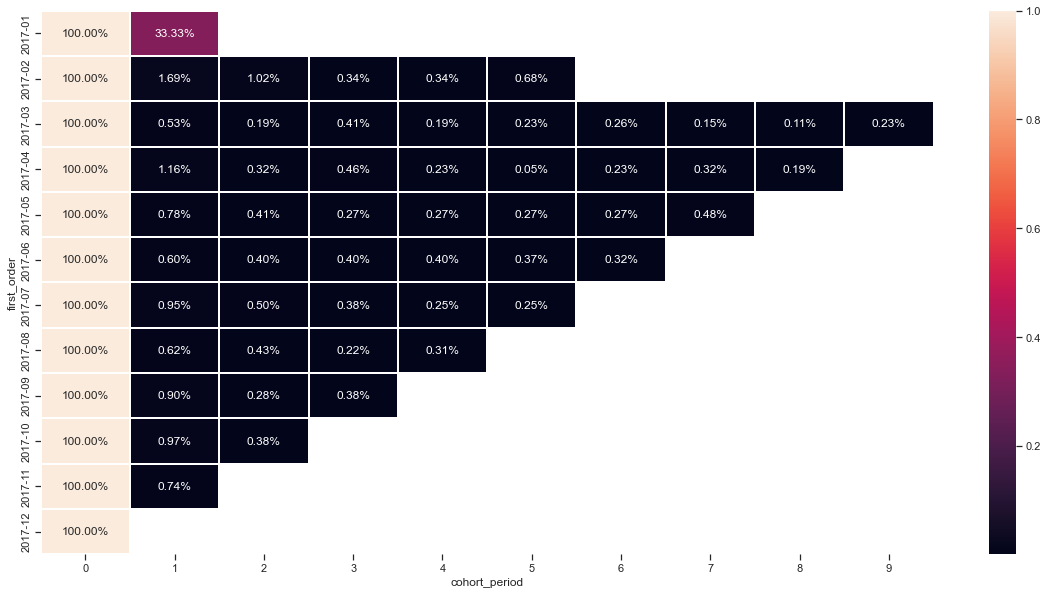

In [101]:
sns.set(style='ticks',
        rc={"figure.figsize": (20, 10)})
sns.heatmap(retention_rate, annot=True, fmt='.2%', linewidth=.3)

На графике видно, что со значением retention rate в 0.46% самый высокий показатель у когорты '2017-04'.

### 6. 
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [108]:
merged_df = pd.merge(orders, customers, on='customer_id')
merged_df = pd.merge(merged_df, order_items, on='order_id')

In [117]:
merged_df = merged_df.query('order_status not in ("canceled", "unavailable")')

In [124]:
import datetime as dt

# Определяем текущую дату (можно заменить на актуальную)
current_date = pd.Timestamp(date.today())

# Расчет Recency (R)
rfm_df = merged_df.groupby('customer_unique_id').agg({
    'order_approved_at': lambda x: (current_date - x.max()).days,
    'order_id': 'count',
    'price': 'sum'
}).reset_index()

# Переименуем колонки для удобства
rfm_df.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

# Отфильтруем клиентов с нулевыми покупками (если есть)
rfm_df = rfm_df[rfm_df['Monetary'] > 0]

In [125]:
rfm_df

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2295.0,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2298.0,1,18.90
2,0000f46a3911fa3c0805444483337064,2721.0,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2505.0,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2472.0,1,180.00
...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2631.0,2,1570.00
94979,fffea47cd6d3cc0a88bd621562a9d061,2446.0,1,64.89
94980,ffff371b4d645b6ecea244b27531430a,2752.0,1,89.90
94981,ffff5962728ec6157033ef9805bacc48,2303.0,1,115.00


In [150]:
def rfm_score(x, metric_name):
    quantile_25 = rfm_df[metric_name].quantile(0.25)
    quantile_50 = rfm_df[metric_name].quantile(0.50)
    quantile_75 = rfm_df[metric_name].quantile(0.75)    
    if x <= quantile_25:
        return 1
    elif x <= quantile_50:
        return 2
    elif x <= quantile_75:
        return 3
    else:
        return 4

In [145]:
rfm_df['R'] = rfm_df['Recency'].apply(rfm_score, 'Recency')
rfm_df['F'] = rfm_df['Frequency'].apply(rfm_score, 'Frequency')
rfm_df['M'] = rfm_df['Monetary'].apply(rfm_score, 'Monetary')

In [151]:
# Объединение в один RFM-сегмент
rfm_df['RFM_Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df['RFM_Score'] = rfm_df[['R', 'F', 'M']].sum(axis=1)

In [156]:
# Функция для описания границ метрик
def describe_rfm_segment(rfm_df, segment):
    subset = rfm_df[rfm_df['RFM_Segment'] == segment]
    recency_range = subset['Recency'].min(), subset['Recency'].max()
    frequency_range = subset['Frequency'].min(), subset['Frequency'].max()
    monetary_range = subset['Monetary'].min(), subset['Monetary'].max()
    return {
        'recency_range': recency_range,
        'frequency_range': frequency_range,
        'monetary_range': monetary_range
    }

# Пример: Описание сегмента 142
segment_description = describe_rfm_segment(rfm_df, '142')
print(segment_description)


{'recency_range': (2185.0, 2298.0), 'frequency_range': (2, 12), 'monetary_range': (47.97, 89.8)}


In [159]:
rfm_grouped = rfm_df.groupby('RFM_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'}).round(1)
rfm_grouped.value_counts().count() # 32 кластеров

32

In [162]:
rfm_graph = rfm_df.groupby('RFM_Segment', as_index=False) \
               .agg({'customer_unique_id': 'count'}) \
               .rename(columns={'customer_unique_id': 'num_of_customers'})
rfm_graph.head()

,RFM_Segment,num_of_customers
0,111,5783
1,112,5308
2,113,5364
3,114,4502
4,141,247


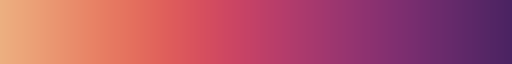

In [163]:
sns.color_palette("flare", as_cmap=True)

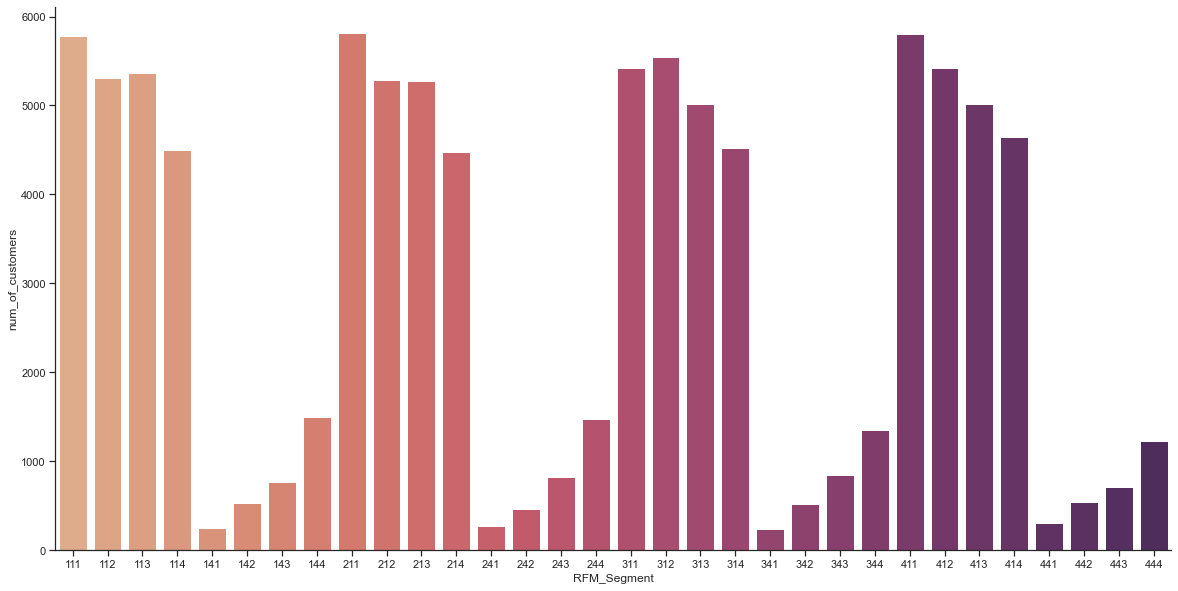

In [164]:
sns.barplot(data=rfm_graph, x='RFM_Segment', y='num_of_customers', palette="flare")
sns.despine()